In [34]:
from pathlib import Path
import xarray as xr
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

In [2]:
basin="CAMELS_UY_16"

In [3]:
# Paths
era_path = Path(f"../MSWEP/filtered_data_MSWEP/time_series/{basin}.nc")
obs_path = Path(f"../preparing_data/cleaned_filtered_data_gauge_precip/time_series/{basin}.nc")
# era_path = Path(f"../preparing_data/filtered_data/time_series/{basin}.nc")
# obs_path = Path("../preparing_data/filtered_data_gauge_precip/time_series/CAMELS_UY_6.nc")
# era_path = Path("../preparing_data/filtered_data/time_series/CAMELS_UY_6.nc")

# Load
ds_obs = xr.open_dataset(obs_path)
ds_era = xr.open_dataset(era_path)

# Extract precipitation
pr_obs = ds_obs["prcp_mm_day"]
pr_era = ds_era["prcp_mm_day"]

# # Align on time (important)
# pr_obs, pr_era = xr.align(pr_obs, pr_era, join="inner")

In [4]:
pr_obs

<xarray.DataArray 'prcp_mm_day' (date: 11322)> Size: 45kB
[11322 values with dtype=float32]
Coordinates:
  * date     (date) datetime64[ns] 91kB 1989-01-01 1989-01-02 ... 2019-12-31
Attributes:
    source:   Gauge (INUMET)

In [5]:
pr_era

<xarray.DataArray 'prcp_mm_day' (date: 11322)> Size: 45kB
[11322 values with dtype=float32]
Coordinates:
  * date     (date) datetime64[ns] 91kB 1989-01-01 1989-01-02 ... 2019-12-31

# Linear Scaling (LS) bias correction function

In [6]:
def linear_scaling_ls(pr_obs: xr.DataArray,
                      pr_era: xr.DataArray,
                      time_dim: str = "date",
                      eps: float = 1e-6) -> xr.DataArray:
    """
    Apply Linear Scaling (LS) bias correction to precipitation.

    Parameters
    ----------
    pr_obs : xr.DataArray
        Observed daily precipitation (e.g., gauge).
    pr_era : xr.DataArray
        ERA5 (or other reanalysis) daily precipitation to be corrected.
    time_dim : str, optional
        Name of the time dimension (default: "date").
    eps : float, optional
        Small value to avoid division by zero.

    Returns
    -------
    xr.DataArray
        LS-corrected daily precipitation.
    """

    # Add month coordinate (version-safe)
    pr_obs = pr_obs.assign_coords(
        month=pr_obs[time_dim].dt.month
    )
    pr_era = pr_era.assign_coords(
        month=pr_era[time_dim].dt.month
    )

    # Monthly means
    obs_monthly_mean = pr_obs.groupby("month").mean(time_dim)
    era_monthly_mean = pr_era.groupby("month").mean(time_dim)

    # Scaling factor (per month)
    scaling_factor = obs_monthly_mean / (era_monthly_mean + eps)

    # Apply LS correction
    pr_era_ls = pr_era.groupby(f"{time_dim}.month") * scaling_factor

    # Metadata
    pr_era_ls = pr_era_ls.assign_attrs({
        "bias_correction": "Linear Scaling (LS)",
        # "reference": "Teutschbein & Seibert (2012)",
        "source_data": pr_era.attrs.get("source", "ERA5")
    })

    return pr_era_ls

In [7]:
pr_era_ls = linear_scaling_ls(pr_obs, pr_era)
pr_era_ls

<xarray.DataArray 'prcp_mm_day' (date: 11322)> Size: 45kB
array([ 0.        ,  0.        ,  0.        , ...,  0.60749346,
       38.026752  , 14.077493  ], dtype=float32)
Coordinates:
  * date     (date) datetime64[ns] 91kB 1989-01-01 1989-01-02 ... 2019-12-31
    month    (date) int64 91kB 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Attributes:
    bias_correction:  Linear Scaling (LS)
    source_data:      ERA5

In [8]:
# OUT_DIR_ls = Path("./filtered_date_precip_ls/time_series")  # <- you choose
OUT_DIR_ls = Path("./mswep_filtered_date_precip_ls/time_series")  # <- you choose
OUT_DIR_ls.mkdir(parents=True, exist_ok=True)

out_path_ls = OUT_DIR_ls / f"{basin}.nc"

In [9]:
out_ls = ds_era.copy(deep=True)

# Replace ERA5 precipitation with LS-corrected precipitation
out_ls["prcp_mm_day"] = pr_era_ls

# # Optional but recommended: document the correction
# out_ls["prcp_mm_day"].attrs.update({
#     "long_name": "Daily precipitation",
#     "units": "mm/day",
#     "bias_correction": "Distribution Mapping (Gamma)",
#     "reference_observations": "CAMELS_UY_6 gauge precipitation",
#     "temporal_resolution": "daily",
#     "note": "Monthly DM with wet-day threshold = 0.1 mm"
# })

In [10]:
out_ls.to_netcdf(out_path_ls)

# LOCI bias correction

In [11]:
def local_intensity_scaling_loci(
    pr_obs: xr.DataArray,
    pr_era: xr.DataArray,
    time_dim: str = "date",
    wet_threshold_obs: float = 0.0,
    eps: float = 1e-6
) -> xr.DataArray:
    """
    Apply Local Intensity Scaling (LOCI) bias correction to precipitation.

    Parameters
    ----------
    pr_obs : xr.DataArray
        Observed daily precipitation.
    pr_era : xr.DataArray
        Reanalysis / model daily precipitation to be corrected.
    time_dim : str, optional
        Name of the time dimension (default: "date").
    wet_threshold_obs : float, optional
        Threshold (mm/day) defining a wet day in observations (default: 0.0).
    eps : float, optional
        Small value to avoid division by zero.

    Returns
    -------
    xr.DataArray
        LOCI-corrected daily precipitation.
    """

    # --- Safety checks -----------------------------------------------------
    if time_dim not in pr_obs.dims or time_dim not in pr_era.dims:
        raise ValueError(f"{time_dim} must be a dimension of both inputs")

    # --- Add month coordinate ---------------------------------------------
    pr_obs = pr_obs.assign_coords(month=pr_obs[time_dim].dt.month)
    pr_era = pr_era.assign_coords(month=pr_era[time_dim].dt.month)

    corrected_months = []

    # --- LOCI applied month by month --------------------------------------
    for m in range(1, 13):

        # Select data for this month
        obs_m = pr_obs.where(pr_obs["month"] == m, drop=True)
        era_m = pr_era.where(pr_era["month"] == m, drop=True)

        # Number of observed wet days
        n_wet_obs = (obs_m > wet_threshold_obs).sum().item()

        # If no wet days or no ERA data → all dry
        if n_wet_obs == 0 or era_m.size == 0:
            corrected_months.append(xr.zeros_like(era_m))
            continue

        # ERA wet-day threshold (keep n_wet_obs rainiest days)
        era_sorted = np.sort(era_m.values)
        idx = max(len(era_sorted) - n_wet_obs, 0)
        p_thres = era_sorted[idx]

        # Wet-day totals
        obs_wet_total = obs_m.where(obs_m > wet_threshold_obs).sum()
        era_wet_total = era_m.where(era_m > p_thres).sum()

        # Scaling factor
        s_m = obs_wet_total / (era_wet_total + eps)

        # Apply LOCI correction
        era_m_loci = xr.where(
            era_m < p_thres,
            0.0,
            era_m * s_m
        )

        corrected_months.append(era_m_loci)

    # --- Recombine months --------------------------------------------------
    pr_loci = xr.concat(corrected_months, dim=time_dim).sortby(time_dim)

    # --- Metadata ----------------------------------------------------------
    pr_loci = pr_loci.assign_attrs({
        "bias_correction": "Local Intensity Scaling (LOCI)",
        "reference": "Schmidli et al. (2006); Teutschbein & Seibert (2012)",
        "source_data": pr_era.attrs.get("source", "ERA5")
    })

    return pr_loci


In [12]:
pr_era_loci = local_intensity_scaling_loci(pr_obs, pr_era)
pr_era_loci

<xarray.DataArray 'prcp_mm_day' (date: 11322)> Size: 45kB
array([ 0.      ,  0.      ,  0.      , ...,  0.      , 40.334606,
       14.931859], dtype=float32)
Coordinates:
  * date     (date) datetime64[ns] 91kB 1989-01-01 1989-01-02 ... 2019-12-31
    month    (date) int64 91kB 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Attributes:
    bias_correction:  Local Intensity Scaling (LOCI)
    reference:        Schmidli et al. (2006); Teutschbein & Seibert (2012)
    source_data:      ERA5

In [13]:
# OUT_DIR_loci = Path("./filtered_date_precip_loci/time_series")  # <- you choose
OUT_DIR_loci = Path("./mswep_filtered_date_precip_loci/time_series")  # <- you choose
OUT_DIR_loci.mkdir(parents=True, exist_ok=True)

out_path_loci = OUT_DIR_loci / f"{basin}.nc"

In [14]:
out_loci = ds_era.copy(deep=True)

# Replace ERA5 precipitation with DM-corrected precipitation
out_loci["prcp_mm_day"] = pr_era_loci

# # Optional but recommended: document the correction
# out_loci["prcp_mm_day"].attrs.update({
#     "long_name": "Daily precipitation",
#     "units": "mm/day",
#     "bias_correction": "Distribution Mapping (Gamma)",
#     "reference_observations": "CAMELS_UY_6 gauge precipitation",
#     "temporal_resolution": "daily",
#     "note": "Monthly DM with wet-day threshold = 0.1 mm"
# })

In [15]:
out_loci.to_netcdf(out_path_loci)

# Power Transformation (PT)

In [16]:
def power_transformation_pt(
    pr_obs: xr.DataArray,
    pr_era: xr.DataArray,
    time_dim: str = "date",
    wet_threshold_obs: float = 0.0,
    eps: float = 1e-6,
    b_min: float = 0.1,
    b_max: float = 5.0,
    n_b: int = 500
) -> xr.DataArray:
    """
    Apply LOCI followed by Power Transformation (PT).
    LOCI is applied by calling the existing LOCI function internally.
    """

    # ------------------------------------------------------------------
    # 1) APPLY LOCI (your existing function)
    # ------------------------------------------------------------------
    pr_loci = local_intensity_scaling_loci(
        pr_obs=pr_obs,
        pr_era=pr_era,
        time_dim=time_dim,
        wet_threshold_obs=wet_threshold_obs,
        eps=eps
    )

    # ------------------------------------------------------------------
    # 2) APPLY POWER TRANSFORMATION (monthly)
    # ------------------------------------------------------------------
    pr_obs = pr_obs.assign_coords(month=pr_obs[time_dim].dt.month)
    pr_loci = pr_loci.assign_coords(month=pr_loci[time_dim].dt.month)

    corrected_months = []
    b_vals = np.linspace(b_min, b_max, n_b)

    for m in range(1, 13):

        obs_m = pr_obs.where(pr_obs["month"] == m, drop=True)
        loci_m = pr_loci.where(pr_loci["month"] == m, drop=True)

        # Use wet days only
        obs_pos = obs_m.where(obs_m > 0, drop=True)
        loci_pos = loci_m.where(loci_m > 0, drop=True)

        # If insufficient data → keep LOCI result
        if obs_pos.size < 10 or loci_pos.size < 10:
            corrected_months.append(loci_m)
            continue

        # Observed coefficient of variation
        cv_obs = obs_pos.std() / obs_pos.mean()

        # --- Grid search for b_m ----------------------------------------
        errors = np.zeros(len(b_vals))
        for i, b in enumerate(b_vals):
            pl = loci_pos ** b
            cv_model = pl.std() / pl.mean()
            errors[i] = abs(cv_obs - cv_model)

        b_m = b_vals[np.argmin(errors)]

        # --- PT scaling factor (restore mean) ---------------------------
        s_m = obs_pos.mean() / ((loci_pos ** b_m).mean() + eps)

        # --- Apply PT ---------------------------------------------------
        pr_cor_m = xr.where(
            loci_m > 0,
            s_m * (loci_m ** b_m),
            0.0
        )

        corrected_months.append(pr_cor_m)

    # ------------------------------------------------------------------
    # 3) RECOMBINE MONTHS
    # ------------------------------------------------------------------
    pr_corrected = xr.concat(corrected_months, dim=time_dim).sortby(time_dim)

    # ------------------------------------------------------------------
    # 4) METADATA
    # ------------------------------------------------------------------
    pr_corrected = pr_corrected.assign_attrs({
        "bias_correction": "LOCI + Power Transformation (grid search)",
        "reference": "Schmidli et al. (2006); Teutschbein & Seibert (2012)",
        "source_data": pr_era.attrs.get("source", "ERA5")
    })

    return pr_corrected


In [17]:
pr_era_pt = power_transformation_pt(pr_obs, pr_era)
pr_era_pt

<xarray.DataArray 'prcp_mm_day' (date: 11322)> Size: 91kB
array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
       42.44134018, 13.0087824 ])
Coordinates:
  * date     (date) datetime64[ns] 91kB 1989-01-01 1989-01-02 ... 2019-12-31
    month    (date) int64 91kB 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Attributes:
    bias_correction:  LOCI + Power Transformation (grid search)
    reference:        Schmidli et al. (2006); Teutschbein & Seibert (2012)
    source_data:      ERA5

In [18]:
# OUT_DIR_pt = Path("./filtered_date_precip_pt/time_series")  # <- you choose
OUT_DIR_pt = Path("./mswep_filtered_date_precip_pt/time_series")  # <- you choose
OUT_DIR_pt.mkdir(parents=True, exist_ok=True)

out_path_pt = OUT_DIR_pt / f"{basin}.nc"

In [19]:
out_pt = ds_era.copy(deep=True)

# Replace ERA5 precipitation with DM-corrected precipitation
out_pt["prcp_mm_day"] = pr_era_pt

# # Optional but recommended: document the correction
# out_pt["prcp_mm_day"].attrs.update({
#     "long_name": "Daily precipitation",
#     "units": "mm/day",
#     "bias_correction": "Distribution Mapping (Gamma)",
#     "reference_observations": "CAMELS_UY_6 gauge precipitation",
#     "temporal_resolution": "daily",
#     "note": "Monthly DM with wet-day threshold = 0.1 mm"
# })

In [20]:
out_pt.to_netcdf(out_path_pt)

# DM correction

In [21]:
import numpy as np
import xarray as xr
from scipy.stats import gamma


def loci_segmented_distribution_mapping_gamma(
    pr_obs: xr.DataArray,
    pr_era: xr.DataArray,
    time_dim: str = "date",
    wet_threshold: float = 0.0,
    q_low: float = 10.0,
    q_high: float = 90.0,
    eps: float = 1e-6
) -> xr.DataArray:
    """
    Apply Local Intensity Scaling (LOCI) followed by segmented
    Gamma Distribution Mapping (DM) using q_low–q_high quantiles.

    Parameters
    ----------
    pr_obs : xr.DataArray
        Observed daily precipitation.
    pr_era : xr.DataArray
        ERA5 daily precipitation.
    time_dim : str
        Name of the time dimension.
    wet_threshold : float
        Wet-day threshold (mm/day).
    q_low, q_high : float
        Lower and upper quantiles (%) defining intensity segments.
    eps : float
        Small value to avoid numerical issues.

    Returns
    -------
    xr.DataArray
        LOCI + segmented DM corrected precipitation.
    """

    # --------------------------------------------------
    # 1. Apply LOCI
    # --------------------------------------------------
    pr_loci = local_intensity_scaling_loci(
        pr_obs=pr_obs,
        pr_era=pr_era,
        time_dim=time_dim,
        wet_threshold_obs=wet_threshold,
        eps=eps
    )

    # Add month coordinate
    pr_loci = pr_loci.assign_coords(month=pr_loci[time_dim].dt.month)
    pr_obs  = pr_obs.assign_coords(month=pr_obs[time_dim].dt.month)

    corrected_months = []

    # --------------------------------------------------
    # 2. Month-by-month segmented DM
    # --------------------------------------------------
    for m in range(1, 13):

        loci_m = pr_loci.where(pr_loci["month"] == m, drop=True)
        obs_m  = pr_obs.where(pr_obs["month"] == m, drop=True)

        # Wet days only
        loci_wet = loci_m.where(loci_m > wet_threshold, drop=True)
        obs_wet  = obs_m.where(obs_m > wet_threshold, drop=True)

        # If not enough data → skip DM
        if loci_wet.size < 10 or obs_wet.size < 10:
            corrected_months.append(loci_m)
            continue

        # --------------------------------------------------
        # 3. Quantile thresholds (from LOCI series)
        # --------------------------------------------------
        p_low  = np.percentile(loci_wet.values, q_low)
        p_high = np.percentile(loci_wet.values, q_high)

        # Prepare output for this month
        loci_dm_m = xr.zeros_like(loci_m)

        # --------------------------------------------------
        # 4. Helper: gamma DM for one segment
        # --------------------------------------------------
        def dm_gamma_segment(x_loci, x_obs):
            if x_loci.size < 5 or x_obs.size < 5:
                return x_loci.values

            a_l, _, b_l = gamma.fit(x_loci.values, floc=0)
            a_o, _, b_o = gamma.fit(x_obs.values,  floc=0)

            cdf = gamma.cdf(x_loci.values, a_l, scale=b_l)
            return gamma.ppf(cdf, a_o, scale=b_o)

        # --------------------------------------------------
        # 5. LOW segment (≤ p_low)
        # --------------------------------------------------
        loci_low = loci_wet.where(loci_wet <= p_low, drop=True)
        obs_low  = obs_wet.where(obs_wet <= p_low, drop=True)

        if loci_low.size > 0:
            mapped_low = dm_gamma_segment(loci_low, obs_low)
            loci_dm_m.loc[loci_low[time_dim]] = mapped_low

        # --------------------------------------------------
        # 6. MID segment (p_low < x ≤ p_high)
        # --------------------------------------------------
        loci_mid = loci_wet.where(
            (loci_wet > p_low) & (loci_wet <= p_high), drop=True
        )
        obs_mid = obs_wet.where(
            (obs_wet > p_low) & (obs_wet <= p_high), drop=True
        )

        if loci_mid.size > 0:
            mapped_mid = dm_gamma_segment(loci_mid, obs_mid)
            loci_dm_m.loc[loci_mid[time_dim]] = mapped_mid

        # --------------------------------------------------
        # 7. HIGH segment (> p_high)
        # --------------------------------------------------
        loci_high = loci_wet.where(loci_wet > p_high, drop=True)
        obs_high  = obs_wet.where(obs_wet > p_high, drop=True)

        if loci_high.size > 0:
            mapped_high = dm_gamma_segment(loci_high, obs_high)
            loci_dm_m.loc[loci_high[time_dim]] = mapped_high

        corrected_months.append(loci_dm_m)

    # --------------------------------------------------
    # 8. Reassemble full time series
    # --------------------------------------------------
    pr_dm = xr.concat(corrected_months, dim=time_dim).sortby(time_dim)

    pr_dm = pr_dm.assign_attrs({
        "bias_correction": "LOCI + segmented Gamma Distribution Mapping",
        "segmentation": f"{q_low}–{q_high} percentiles",
        "wet_day_threshold": wet_threshold,
        "reference": "Schmidli et al. (2006); Themessl et al. (2011)",
        "source_data": pr_era.attrs.get("source", "ERA5")
    })

    return pr_dm


In [22]:
import numpy as np
import xarray as xr
from scipy.stats import gamma

def loci_distribution_mapping_gamma(
    pr_obs: xr.DataArray,
    pr_era: xr.DataArray,
    time_dim: str = "date",
    wet_threshold: float = 0.0,
    eps: float = 1e-6
) -> xr.DataArray:
    """
    Apply LOCI followed by Gamma Distribution Mapping (DM).

    Parameters
    ----------
    pr_obs : xr.DataArray
        Observed daily precipitation.
    pr_era : xr.DataArray
        ERA5 daily precipitation.
    time_dim : str
        Time dimension name.
    wet_threshold : float
        Wet-day threshold (mm/day).
    eps : float
        Small value to avoid numerical issues.

    Returns
    -------
    xr.DataArray
        LOCI + DM corrected precipitation.
    """

    # --------------------------------------------------
    # 1. Apply LOCI first
    # --------------------------------------------------
    pr_loci = local_intensity_scaling_loci(
        pr_obs=pr_obs,
        pr_era=pr_era,
        time_dim=time_dim,
        wet_threshold_obs=wet_threshold,
        eps=eps
    )

    # Add month coordinate
    pr_loci = pr_loci.assign_coords(month=pr_loci[time_dim].dt.month)
    pr_obs  = pr_obs.assign_coords(month=pr_obs[time_dim].dt.month)

    corrected_months = []

    # --------------------------------------------------
    # 2. Distribution Mapping month by month
    # --------------------------------------------------
    for m in range(1, 13):

        loci_m = pr_loci.where(pr_loci["month"] == m, drop=True)
        obs_m  = pr_obs.where(pr_obs["month"] == m, drop=True)

        # Wet days
        wet_loci = loci_m > wet_threshold
        wet_obs  = obs_m  > wet_threshold

        loci_wet = loci_m.where(wet_loci, drop=True)
        obs_wet  = obs_m.where(wet_obs, drop=True)

        # If insufficient data → skip DM
        if loci_wet.size < 5 or obs_wet.size < 5:
            corrected_months.append(loci_m)
            continue

        # --------------------------------------------------
        # 3. Fit gamma distributions
        # --------------------------------------------------
        alpha_l, loc_l, beta_l = gamma.fit(loci_wet.values, floc=0)
        alpha_o, loc_o, beta_o = gamma.fit(obs_wet.values,  floc=0)

        # --------------------------------------------------
        # 4. CDF mapping
        # --------------------------------------------------
        cdf_vals = gamma.cdf(loci_wet.values, alpha_l, scale=beta_l)
        mapped_vals = gamma.ppf(cdf_vals, alpha_o, scale=beta_o)

        # --------------------------------------------------
        # 5. Insert mapped values (dry days remain zero)
        # --------------------------------------------------
        loci_dm_m = xr.zeros_like(loci_m)
        loci_dm_m.loc[loci_wet[time_dim]] = mapped_vals

        corrected_months.append(loci_dm_m)

    # --------------------------------------------------
    # 6. Reassemble full time series
    # --------------------------------------------------
    pr_dm = xr.concat(corrected_months, dim=time_dim).sortby(time_dim)

    pr_dm = pr_dm.assign_attrs({
        "bias_correction": "LOCI + Gamma Distribution Mapping",
        "reference": "Schmidli et al. (2006); Themessl et al. (2011)",
        "source_data": pr_era.attrs.get("source", "ERA5")
    })

    return pr_dm


In [23]:
pr_era_dm = loci_distribution_mapping_gamma(pr_obs, pr_era)
# pr_era_dm = loci_segmented_distribution_mapping_gamma(pr_obs, pr_era)


In [24]:
pr_era_dm

<xarray.DataArray 'prcp_mm_day' (date: 11322)> Size: 45kB
array([ 0.      ,  0.      ,  0.      , ...,  0.      , 44.005325,
       13.077836], dtype=float32)
Coordinates:
  * date     (date) datetime64[ns] 91kB 1989-01-01 1989-01-02 ... 2019-12-31
    month    (date) int64 91kB 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Attributes:
    bias_correction:  LOCI + Gamma Distribution Mapping
    reference:        Schmidli et al. (2006); Themessl et al. (2011)
    source_data:      ERA5

In [25]:
# OUT_DIR = Path("./filtered_date_precip_dm/time_series")  # <- you choose
OUT_DIR = Path("./mswep_filtered_date_precip_dm/time_series")  # <- you choose
OUT_DIR.mkdir(parents=True, exist_ok=True)

out_path = OUT_DIR / f"{basin}.nc"

In [26]:
out_ds = ds_era.copy(deep=True)

# Replace ERA5 precipitation with DM-corrected precipitation
out_ds["prcp_mm_day"] = pr_era_dm

# # Optional but recommended: document the correction
# out_ds["prcp_mm_day"].attrs.update({
#     "long_name": "Daily precipitation",
#     "units": "mm/day",
#     "bias_correction": "Distribution Mapping (Gamma)",
#     "reference_observations": "CAMELS_UY_6 gauge precipitation",
#     "temporal_resolution": "daily",
#     "note": "Monthly DM with wet-day threshold = 0.1 mm"
# })


In [27]:
out_ds.to_netcdf(out_path)

# Methods comparison

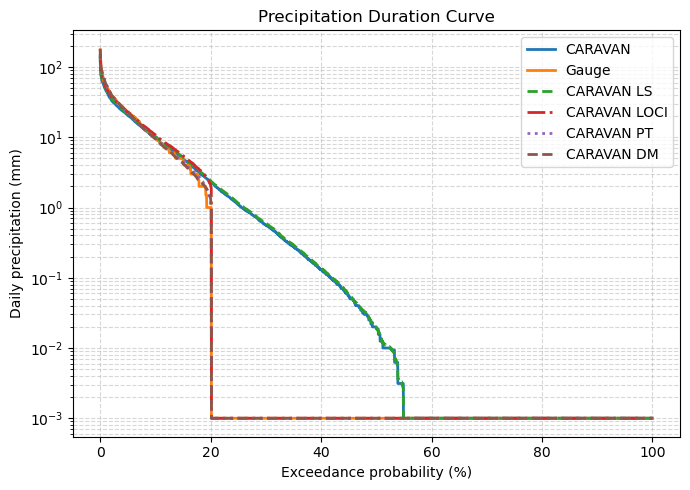

In [28]:
# # --- Extract precipitation ---
# pr_caravan = caravan_6_trimmed["total_precipitation_sum"].values
# pr_gauge = uy_gauge_6["prcp_mm_day"].values

# --- Flatten & remove NaNs ---
pr_caravan = pr_era[~np.isnan(pr_era)]
pr_gauge = pr_obs[~np.isnan(pr_obs)]
pr_ls= pr_era_ls[~np.isnan(pr_era_ls)]
pr_loci = pr_era_loci[~np.isnan(pr_era_loci)]
pr_pt = pr_era_pt[~np.isnan(pr_era_pt)]
pr_corr=pr_era_dm[~np.isnan(pr_era_dm)]

# --- Sort descending ---
pr_caravan_sorted = np.sort(pr_caravan)[::-1]
pr_gauge_sorted = np.sort(pr_gauge)[::-1]
pr_ls_sorted = np.sort(pr_ls)[::-1]
pr_loci_sorted = np.sort(pr_loci)[::-1]
pr_pt_sorted = np.sort(pr_pt)[::-1]
pr_corr_sorted = np.sort(pr_corr)[::-1]

# --- Exceedance probabilities ---
n_caravan = len(pr_caravan_sorted)
n_gauge = len(pr_gauge_sorted)
n_ls = len(pr_ls_sorted)
n_loci = len(pr_loci_sorted)
n_pt = len(pr_pt_sorted)
n_corr = len(pr_corr_sorted)

ep_caravan = np.arange(1, n_caravan + 1) / (n_caravan + 1) * 100
ep_gauge = np.arange(1, n_gauge + 1) / (n_gauge + 1) * 100
ep_ls = np.arange(1, n_ls + 1) / (n_ls + 1) * 100
ep_loci = np.arange(1, n_loci + 1) / (n_loci + 1) * 100
ep_pt = np.arange(1, n_pt + 1) / (n_pt + 1) * 100
ep_corr = np.arange(1, n_corr + 1) / (n_corr + 1) * 100

# --- Plot ---
pr_caravan_plot = np.where(pr_caravan_sorted==0, 1e-3, pr_caravan_sorted)
pr_gauge_plot   = np.where(pr_gauge_sorted==0, 1e-3, pr_gauge_sorted)
pr_ls_plot   = np.where(pr_ls_sorted==0, 1e-3, pr_ls_sorted)
pr_loci_plot   = np.where(pr_loci_sorted==0, 1e-3, pr_loci_sorted)
pr_pt_plot   = np.where(pr_pt_sorted==0, 1e-3, pr_pt_sorted)
pr_corr_plot   = np.where(pr_corr_sorted==0, 1e-3, pr_corr_sorted)

plt.figure(figsize=(7, 5))

plt.plot(ep_caravan, pr_caravan_plot, label="CARAVAN", lw=2)
plt.plot(ep_gauge, pr_gauge_plot, label="Gauge", lw=2)
plt.plot(ep_ls, pr_ls_plot, label="CARAVAN LS", lw=2, ls="--")
plt.plot(ep_loci, pr_loci_plot, label="CARAVAN LOCI", lw=2, ls="-.")
plt.plot(ep_pt, pr_pt_plot, label="CARAVAN PT", lw=2, ls=":")
plt.plot(ep_corr, pr_corr_plot, label="CARAVAN DM", lw=2, ls="--")

plt.xlabel("Exceedance probability (%)")
plt.ylabel("Daily precipitation (mm)")
plt.yscale("log")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.title("Precipitation Duration Curve")
# plt.xlim(0,60)

plt.tight_layout()
plt.show()

In [29]:
## Dry length

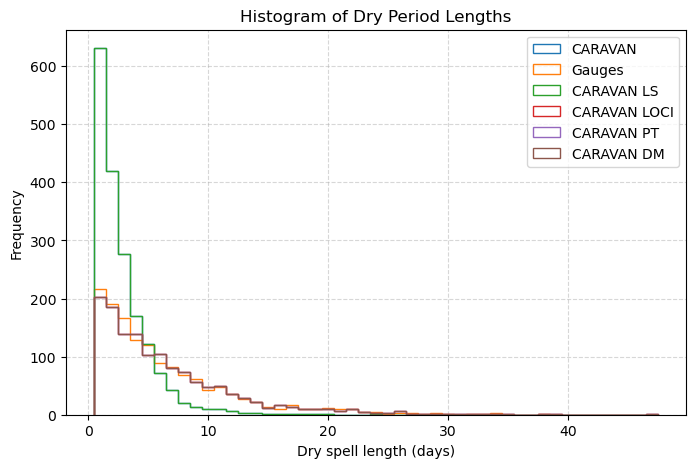

In [30]:
# --- Step 1: Define function to get consecutive zeros ---
def get_consecutive_lengths(bool_array):
    diff = np.diff(bool_array.astype(int))
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1
    if bool_array[0]:
        starts = np.r_[0, starts]
    if bool_array[-1]:
        ends = np.r_[ends, len(bool_array)]
    lengths = ends - starts
    return lengths

# --- Step 2: Convert to boolean arrays for both datasets ---
dry_caravan = (pr_era == 0)
dry_camels   = (pr_obs   == 0)
dry_ls = (pr_era_ls == 0)
dry_loci = (pr_era_loci == 0)
dry_pt = (pr_era_pt == 0)
dry_dm = (pr_era_dm == 0)

# --- Step 3: Get consecutive zero lengths ---
dry_lengths_caravan = get_consecutive_lengths(dry_caravan)
dry_lengths_camels   = get_consecutive_lengths(dry_camels)
dry_lengths_ls = get_consecutive_lengths(dry_ls)
dry_lengths_loci = get_consecutive_lengths(dry_loci)
dry_lengths_pt = get_consecutive_lengths(dry_pt)
dry_lengths_dm = get_consecutive_lengths(dry_dm)

# --- Step 4: Plot histograms together ---
plt.figure(figsize=(8,5))

max_len = max(
    dry_lengths_caravan.max(),
    dry_lengths_camels.max(),
    dry_lengths_ls.max(),
    dry_lengths_loci.max(),
    dry_lengths_pt.max(),
    dry_lengths_dm.max()
)

bins = np.arange(1, max_len + 2) - 0.5

plt.hist(dry_lengths_caravan, bins=bins, histtype="step", lw=2, label="CARAVAN")
plt.hist(dry_lengths_camels,   bins=bins, histtype="step", lw=2, label="Gauges")
plt.hist(dry_lengths_ls,   bins=bins, histtype="step", lw=2, label="CARAVAN LS")
plt.hist(dry_lengths_loci,   bins=bins, histtype="step", lw=2, label="CARAVAN LOCI")
plt.hist(dry_lengths_pt,   bins=bins, histtype="step", lw=2, label="CARAVAN PT")
plt.hist(dry_lengths_dm,   bins=bins, histtype="step", lw=2, label="CARAVAN DM")

plt.xlabel("Dry spell length (days)")
plt.ylabel("Frequency")
plt.title("Histogram of Dry Period Lengths")
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.show()

In [31]:
# Accumulated precipitation

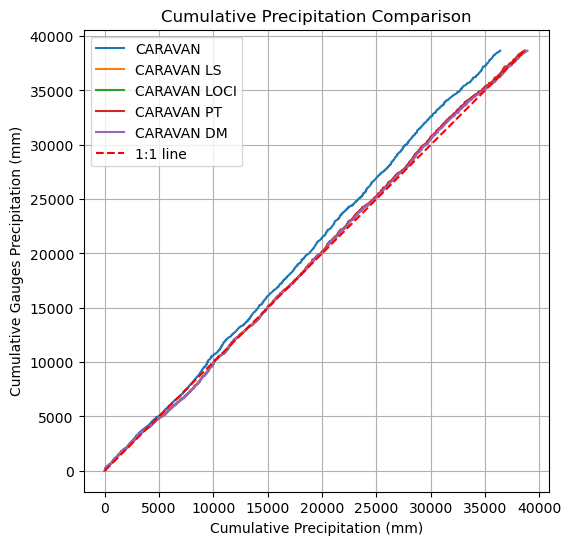

In [32]:
# Compute cumulative precipitation for both series
cum_caravan = pr_era.cumsum(dim='date').values.flatten()
cum_camels = pr_obs.cumsum(dim='date').values.flatten()
cum_ls = pr_era_ls.cumsum(dim='date').values.flatten()
cum_loci = pr_era_loci.cumsum(dim='date').values.flatten()
cum_pt = pr_era_pt.cumsum(dim='date').values.flatten()
cum_dm = pr_era_dm.cumsum(dim='date').values.flatten()

# Scatter plot: x = Caravan, y = UY gauge
plt.figure(figsize=(6,6))
plt.plot(cum_caravan, cum_camels, label='CARAVAN')
plt.plot(cum_ls, cum_camels, label='CARAVAN LS')
plt.plot(cum_loci, cum_camels, label='CARAVAN LOCI')
plt.plot(cum_pt, cum_camels, label='CARAVAN PT')
plt.plot(cum_dm, cum_camels, label='CARAVAN DM')
plt.xlabel('Cumulative Precipitation (mm)')
plt.ylabel('Cumulative Gauges Precipitation (mm)')
plt.title('Cumulative Precipitation Comparison')
plt.grid(True)

# Optional: 1:1 line to see perfect agreement
max_val = max(cum_caravan.max(), cum_camels.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='1:1 line')
plt.legend()
plt.show()

In [ ]:
# LS should fix bias
# LOCI fix wet days and bias
# PT fixes what LOCI fixes and the standar deviation
# DM fixes what LOCI fixes and adjustes the averages, quartiles and standard deviation while preserving extreme values



pr_caravan 
pr_gauge 
pr_ls
pr_loci 
pr_pt 
pr_corr

In [35]:
def compute_metrics(pr, pr_ref, wet_threshold=0.1):
    """Compute diagnostics for a precipitation series."""
    
    # Mean bias
    mean_bias = float(pr.mean() - pr_ref.mean())
    
    # Wet‑day frequency
    wet_freq = float((pr > wet_threshold).mean())
    
    # Standard deviation
    std = float(pr.std())
    
    # Distribution shape (quantiles)
    q10 = float(pr.quantile(0.10))
    q50 = float(pr.quantile(0.50))
    q90 = float(pr.quantile(0.90))
    
    # Extremes
    q95 = float(pr.quantile(0.95))
    q99 = float(pr.quantile(0.99))
    
    return {
        "mean_bias": mean_bias,
        "wet_freq": wet_freq,
        "std": std,
        "q10": q10,
        "q50": q50,
        "q90": q90,
        "q95": q95,
        "q99": q99,
    }

# Put all series in a dict
series = {
    "ERA5_raw": pr_caravan,
    "Gauge": pr_gauge,
    "LS": pr_ls,
    "LOCI": pr_loci,
    "PT": pr_pt,
    "DM": pr_corr,
}

# Compute metrics for each
rows = {}
for name, pr in series.items():
    rows[name] = compute_metrics(pr, pr_gauge)

# Convert to DataFrame
df_metrics = pd.DataFrame(rows).T

df_metrics


,mean_bias,wet_freq,std,q10,q50,q90,q95,q99
ERA5_raw,-1.997747e-01,0.416181,9.109249,0.0,0.018750,9.650000,20.402188,46.654780
Gauge,0.000000e+00,0.201201,11.114336,0.0,0.000000,10.000000,23.000000,54.000000
LS,-1.192093e-06,0.419714,9.762891,0.0,0.019397,10.250916,21.706004,49.502016
LOCI,2.721071e-03,0.201201,10.318483,0.0,0.000000,10.812491,22.797156,52.050338
PT,-2.740204e-07,0.201201,11.115779,0.0,0.000000,9.763237,22.517595,57.494949
DM,2.219081e-02,0.201201,11.341968,0.0,0.000000,9.462726,22.811926,57.796592
